In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/P3DCV/Diff-FMAPs/code/"
import sys
sys.path.insert(0, "/content/drive/MyDrive/P3DCV/Diff-FMAPs/code/")

/content/drive/MyDrive/P3DCV/Diff-FMAPs/code


In [ ]:
!pip install joblib
!pip install plyfile
!pip install polyscope
!pip install scikit-learn
!pip install scipy
!pip install threadpoolctl
!pip install tqdm
!pip install typing-extensions
!pip install libigl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 56.6 MB/s eta 0:00:00


In [ ]:
import igl
import numpy as np
import os
import torch.optim as optim
from model import PointNetBasis, PointNetDesc
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from faust_remeshed_dataset import FaustRDataset
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epoch = 50
lr = 0.00004
decay_every = 9999
decay_rate = 0.1
root_dir = "/content/drive/MyDrive/P3DCV/data/"
train_set = FaustRDataset(root_dir, name="FAUST_r", train=True, n_samples=2048, n_points=5000,  augm=True, uniform=False, use_cache=True)
test_set = FaustRDataset(root_dir, name="FAUST_r", train=False, n_samples=200, n_points=5000,  augm=False, uniform=False, use_cache=True)
train_loader = DataLoader(train_set, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2)
model_id = abs(round(np.random.normal(0, 1), 5))
print(model_id)
model_save_path = "/content/drive/MyDrive/P3DCV/models/"

using dataset cache path: /content/drive/MyDrive/P3DCV/data/FAUST_r/cache/train.npz
  --> loading dataset from cache
using dataset cache path: /content/drive/MyDrive/P3DCV/data/FAUST_r/cache/test.npz
  --> loading dataset from cache
0.08259


In [ ]:
for i, data in enumerate(train_loader):
  print("batch", i)
  verts1, verts2 = data
  verts1 = verts1.to(device)
  verts2 = verts2.to(device)
  print("vertices 1:", verts1.shape)
  print("vertices 2:", verts2.shape)


In [ ]:
basisNet = PointNetBasis(k=100, feature_transform=False)
optim = torch.optim.AdamW(basisNet.parameters(), lr=lr, weight_decay=0.001)
basisNet.to(device)

PointNetBasis(
  (feat): PointNetfeat(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv41): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (conv42): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (conv5): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (dense1): Linear(in_features=1024, out_features=256, bias=True)
    (dense2): Linear(in_features=256, out_features=256, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn41): BatchNorm1d(128, eps=1e-05,

In [ ]:
# Training Loop
epoch_train_loss = []
epoch_val_loss = []
for epoch in range(n_epoch):
    train_losses = []
    val_losses = []
    faust_losses = []
    metrics = []
    # Training single Epoch
    basisNet.train()
    for i, data in enumerate(train_loader):
        vertsA, vertsB = data
        batch = vertsA.shape[0]
        vertsA = vertsA.to(device).to(torch.float32)
        vertsB = vertsB.to(device).to(torch.float32)
        cat_verts = torch.cat([vertsA.transpose(1,2), vertsB.transpose(1,2)], dim=0)
        optim.zero_grad()

        # Obtaining predicted basis
        cat_preds, _, _ = basisNet(cat_verts)#cat_pred.shape (B, n_points, k)

        basisA = cat_preds[:batch, :, :]
        basisB = cat_preds[batch:, :, :]
        # Computing optimal transformation
        pseudo_inv_A = torch.pinverse(basisA)
        C_opt = torch.matmul(pseudo_inv_A, basisB)
        opt_A = torch.matmul(basisA, C_opt)

        # SoftMap
        dist_matrix = torch.cdist(opt_A, basisB)
        s_max = torch.nn.Softmax(dim=1)
        s_max_matrix = s_max(-dist_matrix)

        # Basis Loss
        eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))

        #metric = torch.mean(torch.square(s_max_matrix - torch.identity(s_max_matrix.shape[0]))) # measuring how well we are approximating the ground-truth correspondence
        # Back Prop
        eucl_loss.backward()
        optim.step()
        train_losses.append(eucl_loss.detach().item())
        #metrics.append(metric.detach().item())

    basisNet.eval()
    with torch.no_grad():
      for i, data in enumerate(test_loader):
          vertsA, vertsB = data
          batch = vertsA.shape[0]
          vertsA = vertsA.to(device).to(torch.float32)
          vertsB = vertsB.to(device).to(torch.float32)
          cat_verts = torch.cat([vertsA.transpose(1,2), vertsB.transpose(1,2)], dim=0)
          cat_val_preds, _, _ = basisNet(cat_verts)#cat_pred.shape (B, n_points, k)
          basisA = cat_val_preds[:batch, :, :]
          basisB = cat_val_preds[batch:, :, :]
          # Computing optimal transformation
          pseudo_inv_A = torch.pinverse(basisA)
          C_opt = torch.matmul(pseudo_inv_A, basisB)
          opt_A = torch.matmul(basisA, C_opt)
          # SoftMap
          dist_matrix = torch.cdist(opt_A, basisB)
          s_max = torch.nn.Softmax(dim=1)
          s_max_matrix = s_max(-dist_matrix)
          # Basis Loss
          val_eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))
          val_losses.append(val_eucl_loss.detach().item())

    ave_train_loss = sum(train_losses) / len(train_losses)
    ave_val_loss = sum(val_losses) / len(val_losses)
    #ave_metric = sum(metrics) / len(metrics)
    print()
    print(f"training loss for epoch{epoch}:", ave_train_loss)
    print(f"validation loss for epoch{epoch}:", ave_val_loss)
    #print(f"training metric for epoch{epoch}:", ave_metric)
    torch.save(basisNet.state_dict(), f"/content/drive/MyDrive/P3DCV/models/difffmap_{model_id}_{epoch}.pt")
    epoch_train_loss.append(ave_train_loss)
    epoch_val_loss.append(ave_val_loss)
np.save(f"/content/drive/MyDrive/P3DCV/losses/train/difffmap_{model_id}.npy", np.array(epoch_train_loss))
np.save(f"/content/drive/MyDrive/P3DCV/losses/val/difffmap_{model_id}.npy", np.array(epoch_val_loss))




training loss for epoch0: 451.44492247376263
validation loss for epoch0: 166.42352040608725

training loss for epoch1: 228.52401959383036
validation loss for epoch1: 150.7096757888794

training loss for epoch2: 198.5766544776627
validation loss for epoch2: 141.08630180358887

training loss for epoch3: 181.0322426132009
validation loss for epoch3: 135.15623378753662

training loss for epoch4: 168.88868826371206
validation loss for epoch4: 138.25793933868408

training loss for epoch5: 160.18553317106222
validation loss for epoch5: 134.17592493693033

training loss for epoch6: 152.19317489817172
validation loss for epoch6: 131.71414947509766

training loss for epoch7: 146.26158041652243
validation loss for epoch7: 127.9492073059082

training loss for epoch8: 140.81040022644817
validation loss for epoch8: 129.2856772740682

training loss for epoch9: 136.46772848201704
validation loss for epoch9: 131.00457541147867

training loss for epoch10: 132.50568408241756
validation loss for epoch10:

**visualization train and loss curves**

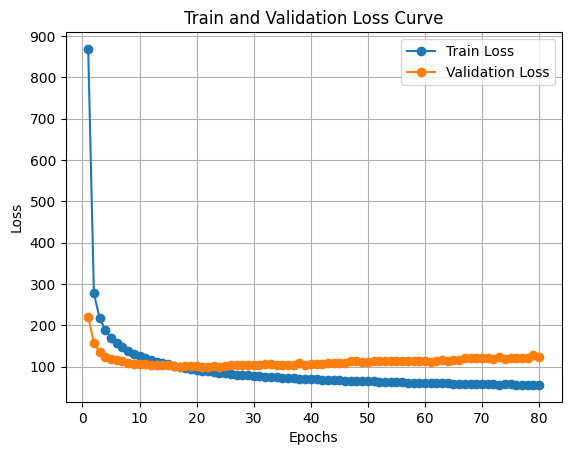

In [ ]:
train_loss_array = np.load(f"/content/drive/MyDrive/P3DCV/losses/train/difffmap_1.76573.npy")
val_loss_array = np.load(f"/content/drive/MyDrive/P3DCV/losses/val/difffmap_1.76573.npy")
epochs = np.arange(1, len(train_loss_array) + 1)

plt.plot(epochs, train_loss_array, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_array, label='Validation Loss', marker='o')

plt.title('Train and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#test loops
for epoch in range(n_epoch):
    train_losses = []
    eval_losses = []
    faust_losses = []
    metrics = []
    # Training single Epoch
    for i, data in enumerate(train_loader):
        vertsA, vertsB = data
        batch = vertsA.shape[0]
        vertsA = vertsA.to(device).to(torch.float32)
        vertsB = vertsB.to(device).to(torch.float32)
        cat_verts = torch.cat([vertsA.transpose(1,2), vertsB.transpose(1,2)], dim=0)
        optim.zero_grad()
        basisNet = basisNet.train()

        # Obtaining predicted basis
        cat_preds, _, _ = basisNet(cat_verts)#cat_pred.shape (B, n_points, k)

        basisA = cat_preds[:batch, :, :]
        basisB = cat_preds[batch:, :, :]
        # Computing optimal transformation
        pseudo_inv_A = torch.pinverse(basisA)
        C_opt = torch.matmul(pseudo_inv_A, basisB)
        opt_A = torch.matmul(basisA, C_opt)

        # SoftMap
        dist_matrix = torch.cdist(opt_A, basisB)
        s_max = torch.nn.Softmax(dim=1)
        s_max_matrix = s_max(-dist_matrix)

        # Basis Loss
        eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))

        #metric = torch.mean(torch.square(s_max_matrix - torch.identity(s_max_matrix.shape[0]))) # measuring how well we are approximating the ground-truth correspondence
        # Back Prop
        eucl_loss.backward()
        optim.step()
        train_losses.append(eucl_loss.detach().item())
        #metrics.append(metric.detach().item())
    ave_train_loss = sum(train_losses) / len(train_losses)
    #ave_metric = sum(metrics) / len(metrics)
    print(f"training loss for epoch{epoch}:", ave_train_loss)
    #print(f"training metric for epoch{epoch}:", ave_metric)
    torch.save(basisNet.state_dict(), f"/content/drive/MyDrive/P3DCV/models/difffmap_resampled_epoch_{epoch}.pt")



In [ ]:
'''

    # Validation
    with torch.no_grad():
        eval_loss = 0
        for data in tqdm(dataset_test, 0):
            points = data[0]
            points = points.transpose(2, 1)
            points = points.cuda()
            basisNet = basisNet.eval()
            pred, _, _ = basisNet(points)
            basis_A = pred[1:,:,:]; basis_B = pred[:-1,:,:]
            pc_A = points[1:,:,:]; pc_B = points[:-1,:,:]

            pseudo_inv_A = torch.pinverse(basis_A)
            C_opt = torch.matmul(pseudo_inv_A, basis_B)
            opt_A = torch.matmul(basis_A, C_opt)

            dist_matrix = torch.cdist(opt_A, basis_B)
            s_max = torch.nn.Softmax(dim=1)
            s_max_matrix = s_max(-dist_matrix)
            eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, torch.transpose(pc_B,1,2)) - torch.transpose(pc_B,1,2)))
            eval_loss +=   eucl_loss.item()

        print('EPOCH ' + str(epoch) + ' - eva_loss: ' + str(eval_loss))

        # Saving if best model so far
        if eval_loss <  best_eval_loss:
            print('save model')
            best_eval_loss = eval_loss
            torch.save(basisNet.state_dict(), '%s/basis_model_best.pth' % (outf))

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)

        # Logging losses
        np.save(outf+'/train_losses_basis.npy',train_losses)
        np.save(outf+'/eval_losses_basis.npy',eval_losses)
'''